# Manafest Destiny - Bloomburrow

![Project logo](images/logo2.png)

Welcome to Manafest Destiny. Our goal is to build a regression model to analyze Magic: the Gathering draft decks from the "Bloomburrow" set. If you are not already familiar with the game, we recommend reading at least the first two sections of the mtg_primer.md which is written to explain the minimum detail needed to follow this project.

## Imports/Data Loading

In [30]:
# Data Handling & Computation
import requests
import pandas as pd
import numpy as np
import os
import gc
from scipy.stats import pearsonr
import ast # For safely evaluating string representations of dictionaries
from collections import Counter
import matplotlib.ticker as mticker
from matplotlib.ticker import FormatStrFormatter

# Machine Learning Models
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans

# Data Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

# Metrics & Visualization
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, mean_absolute_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt

CHOSEN_SET = "blb" # Bloomburrow

In [2]:
color_list = ["W", "U", "B", "R", "G"]
basic_lands = {"Plains", "Island", "Swamp", "Mountain", "Forest"}

# Actually represents GAME data at this point
decks_df = pd.read_parquet(f"data/{CHOSEN_SET}/games.parquet", engine='fastparquet')

### Bloomburrow Games EDA

In [3]:
print(decks_df.shape)
print(decks_df.columns[:20])
decks_df.head(3)

(931230, 1398)
Index(['draft_id', 'draft_ti fome', 'game_time', 'build_index', 'match_number',
       'game_number', 'rank', 'opp_rank', 'main_colors', 'splash_colors',
       'on_play', 'num_mulligans', 'opp_num_mulligans', 'opp_colors',
       'num_turns', 'won', 'opening_hand_Agate Assault', 'drawn_Agate Assault',
       'tutored_Agate Assault', 'deck_Agate Assault'],
      dtype='object')


,draft_id,draft_ti fome,game_time,build_index,match_number,game_number,rank,opp_rank,main_colors,splash_colors,...,"tutored_Ygra, Eater of All","deck_Ygra, Eater of All","sideboard_Ygra, Eater of All","opening_hand_Zoraline, Cosmos Caller","drawn_Zoraline, Cosmos Caller","tutored_Zoraline, Cosmos Caller","deck_Zoraline, Cosmos Caller","sideboard_Zoraline, Cosmos Caller",user_n_games_bucket,user_game_win_rate_bucket
0,deaa4cdcd3e84d8e8b5a0ea34a0f9d79,2024-07-30 22:30:39,2024-07-30 22:58:45,0,1,1,gold,NaN,BG,WR,...,0,1,0,0,0,0,0,0,50,0.54
1,deaa4cdcd3e84d8e8b5a0ea34a0f9d79,2024-07-30 22:30:39,2024-07-30 23:13:12,0,2,1,gold,NaN,BG,WR,...,0,1,0,0,0,0,0,0,50,0.54
2,deaa4cdcd3e84d8e8b5a0ea34a0f9d79,2024-07-30 22:30:39,2024-07-30 23:29:06,0,3,1,gold,NaN,BG,WR,...,0,1,0,0,0,0,0,0,50,0.54


In [4]:
filtered_df = decks_df[['draft_id', 'rank', 'main_colors', 'splash_colors', 'won', 'game_time']]

# Aggregate wins, losses, and retain a representative game_time per draft
summary_df = filtered_df.groupby(['draft_id', 'rank', 'main_colors', 'splash_colors']).agg(
    wins=('won', lambda x: (x == True).sum()),
    losses=('won', lambda x: (x == False).sum()),
    game_time=('game_time', 'first')
).reset_index()
summary_df.to_csv("data/blb/summary.csv", index=False)
print(summary_df.head())

summary_df.shape

                           draft_id    rank main_colors splash_colors  wins  \
0  00012ab72e134fba87e2a0ad2a2b4f9b    gold          BG             W     3   
1  0002f48434bf453da4a2fcb0edf635fd    gold          BG           WUR     2   
2  0002f48434bf453da4a2fcb0edf635fd  silver          BG           WUR     5   
3  0006049f933e42d9acc0f9f49a5c404f  silver          BG             U     2   
4  000715c6d0304feaa63a03b01ca7fec1    gold          BG            UR     2   

   losses            game_time  
0       3  2024-07-31 06:15:05  
1       1  2024-08-12 15:57:52  
2       1  2024-08-12 15:05:37  
3       3  2024-08-15 03:12:13  
4       3  2024-08-11 20:31:40  


(70191, 7)

In [5]:
def categorize_draft(row):
    if row['wins'] == 7 or row['losses'] == 3:
        return f"{row['wins']}-{row['losses']}"
    else:
        return "incomplete"

# Apply categorization
summary_df['record_category'] = summary_df.apply(categorize_draft, axis=1)

# Count occurrences of each record category
record_counts = summary_df['record_category'].value_counts().sort_index()

print(record_counts)

record_category
0-3            5279
1-3            8436
2-3            8750
3-3            7242
4-3            5382
5-3            3684
6-3            2195
7-0             454
7-1            1251
7-2            2282
7-3               2
8-3               1
incomplete    25233
Name: count, dtype: int64


Players in MTG Arena play until reaching 7 wins or 3 losses. We have a few "impossible" drafts which can occur because of a rare bug in online play. Next, we'll look at the incomplete drafts.

In [6]:
# Drop invalid records directly
summary_df = summary_df[~summary_df['record_category'].isin(['7-3', '8-3'])]

# Filter only incomplete drafts
incomplete_df = summary_df[summary_df['record_category'] == 'incomplete']

incomplete_distribution = incomplete_df.groupby(['wins', 'losses']).size().reset_index(name='count')
incomplete_distribution = incomplete_distribution.sort_values(by=['wins', 'losses'])

incomplete_distribution

,wins,losses,count
0,0,1,3299
1,0,2,2086
2,1,0,2354
3,1,1,1980
4,1,2,2099
5,1,4,3
6,2,0,1488
7,2,1,1492
8,2,2,1725
9,2,4,3


In [7]:
# A few more impossible drafts noted above (4 losses)

summary_df['rank'].value_counts()

rank
platinum    26610
gold        15390
silver      10371
diamond      8785
bronze       4560
mythic       4472
Name: count, dtype: int64

In [8]:
# Function to get win rate distribution per rank
def get_rank_distribution(rank_name):
    rank_df = summary_df[summary_df['rank'] == rank_name]
    return rank_df['record_category'].value_counts().sort_index()

# Get distributions for Mythic and Diamond separately
mythic_distribution = get_rank_distribution('mythic')
diamond_distribution = get_rank_distribution('diamond')

# Display results
print("Mythic Win Rate Distribution:\n", mythic_distribution)
print("\nDiamond Win Rate Distribution:\n", diamond_distribution)

Mythic Win Rate Distribution:
 record_category
0-3           360
1-3           595
2-3           643
3-3           578
4-3           400
5-3           317
6-3           210
7-0            44
7-1           126
7-2           223
incomplete    976
Name: count, dtype: int64

Diamond Win Rate Distribution:
 record_category
0-3            789
1-3           1272
2-3           1243
3-3            997
4-3            774
5-3            512
6-3            350
7-0             77
7-1            182
7-2            336
incomplete    2253
Name: count, dtype: int64


### Color Distribution

The five colors are White, Blue, Black, Red, and Green (W, U, B, R, G). We'll examine their distributions. Most decks will use 2 colors.

In [9]:
summary_df['main_colors'].value_counts()

main_colors
BG      14514
WG      11729
UG       9003
RG       6638
WB       6481
WR       5927
UB       3915
BR       3306
WU       2358
UR       1908
W         736
UBG       577
WBG       515
WUG       368
G         356
WRG       335
R         308
B         258
BRG       238
U         207
WUB       141
URG       112
WBR       107
UBR        70
WUR        47
WUBG       11
UBRG        9
WBRG        7
WURG        6
WUBR        1
Name: count, dtype: int64

In [10]:
# Drop records with 4 or more losses
summary_df = summary_df[summary_df['losses'] < 4]

# Add win rate field
summary_df['win_rate'] = summary_df['wins'] / (summary_df['wins'] + summary_df['losses'])

color_win_rates = summary_df.groupby('main_colors').agg(
    total_wins=('wins', 'sum'),
    total_losses=('losses', 'sum')
).reset_index()

# Compute actual win rate
color_win_rates['win_rate'] = color_win_rates['total_wins'] / (color_win_rates['total_wins'] + color_win_rates['total_losses'])

# Sort by win rate for easier analysis
color_win_rates = color_win_rates.sort_values(by='win_rate', ascending=False)

color_win_rates

,main_colors,total_wins,total_losses,win_rate
15,W,2244,1401,0.615638
4,G,917,700,0.567100
5,R,796,653,0.549344
1,BG,38342,32386,0.542105
7,U,512,434,0.541226
16,WB,17209,14593,0.541129
0,B,630,535,0.540773
21,WR,15412,13336,0.536107
20,WG,30431,26362,0.535823
12,UG,23001,20241,0.531913


##### Color Notes

Mono-color decks are surprisingly strong and well-represented. Most decks are focused on one of the two-color "tribes", but this is not essential for success.

### Rank Examination

In [11]:
overall_win_rate = summary_df['wins'].sum() / (summary_df['wins'].sum() + summary_df['losses'].sum())
print(f"Overall Win Rate: {overall_win_rate:.2%}")

rank_win_rates = summary_df.groupby('rank').agg(
    total_wins=('wins', 'sum'),
    total_losses=('losses', 'sum')
).reset_index()

rank_win_rates['win_rate'] = rank_win_rates['total_wins'] / (rank_win_rates['total_wins'] + rank_win_rates['total_losses'])

print(rank_win_rates.sort_values(by='win_rate', ascending=False))

Overall Win Rate: 53.25%
       rank  total_wins  total_losses  win_rate
0    bronze       11514          8060  0.588229
5    silver       25821         20360  0.559126
2      gold       37197         32541  0.533382
3    mythic       12536         11083  0.530759
4  platinum       69745         64212  0.520652
1   diamond       22879         21483  0.515734


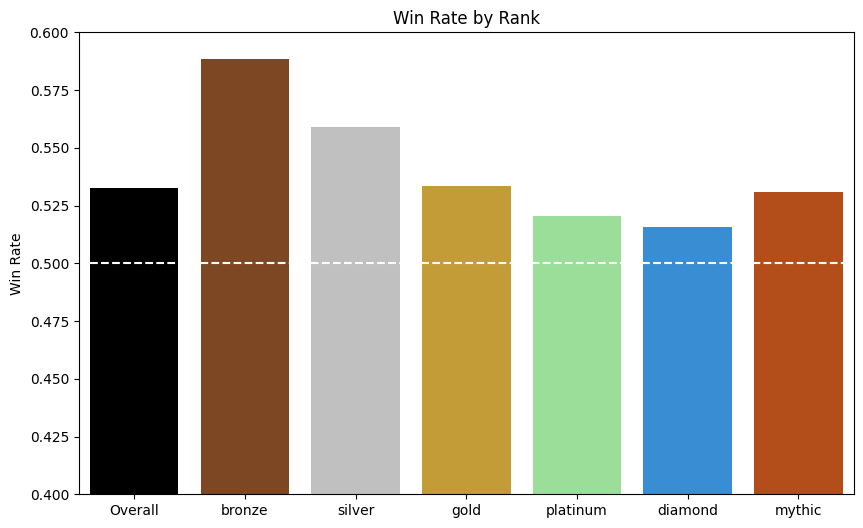

In [12]:
rank_order = ['Overall', 'bronze', 'silver', 'gold', 'platinum', 'diamond', 'mythic']
rank_colors = {
    'bronze': '#8B4513',  # Brown
    'silver': '#C0C0C0',  # Gray
    'gold': '#DAA520',    # Gold
    'platinum': "#8FE98F", # Green
    'diamond': "#2090EB", # Blue
    'mythic': '#CC4400',   # Orange-Red,
    'Overall': '#000000'  # Black for overall win rate
}

# Compute overall win rate
overall_win_rate = summary_df['wins'].sum() / (summary_df['wins'].sum() + summary_df['losses'].sum())

# Create DataFrame for visualization
rank_win_rates = summary_df.groupby('rank').agg(
    total_wins=('wins', 'sum'),
    total_losses=('losses', 'sum')
).reset_index()

rank_win_rates['win_rate'] = rank_win_rates['total_wins'] / (rank_win_rates['total_wins'] + rank_win_rates['total_losses'])

# Append overall win rate
overall_df = pd.DataFrame({'rank': ['Overall'], 'win_rate': [overall_win_rate]})
rank_win_rates = pd.concat([overall_df, rank_win_rates], ignore_index=True)

# Ensure correct rank order
rank_win_rates['rank'] = pd.Categorical(rank_win_rates['rank'], categories=rank_order, ordered=True)
rank_win_rates = rank_win_rates.sort_values('rank')

# Assign colors to ranks
rank_win_rates['color'] = rank_win_rates['rank'].map(rank_colors)

# Plot the bar graph
plt.figure(figsize=(10, 6))
sns.barplot(
    x='rank',
    y='win_rate',
    hue='rank',
    data=rank_win_rates,
    palette=rank_colors,
    legend=False
)

# Adjust y-axis range
plt.ylim(0.4, 0.6)

# Add a dashed white line at 0.5
plt.axhline(0.5, color='white', linestyle='dashed', linewidth=1.5)

plt.title('Win Rate by Rank')
plt.ylabel('Win Rate')
plt.xlabel('')
plt.xticks()

plt.show()

##### Rank Analysis Note

This is surprising, but also makes sense as we consider the matchmaking system. MTG Arena does partial resets of player rankings for each set. This means that (especially in our self-selected/biased sample) Bronze players are not necessarily bad players; they're usually good players who quickly distinguish themselves and move on to more challenging brackets.

### Tribes/Colors by Rank

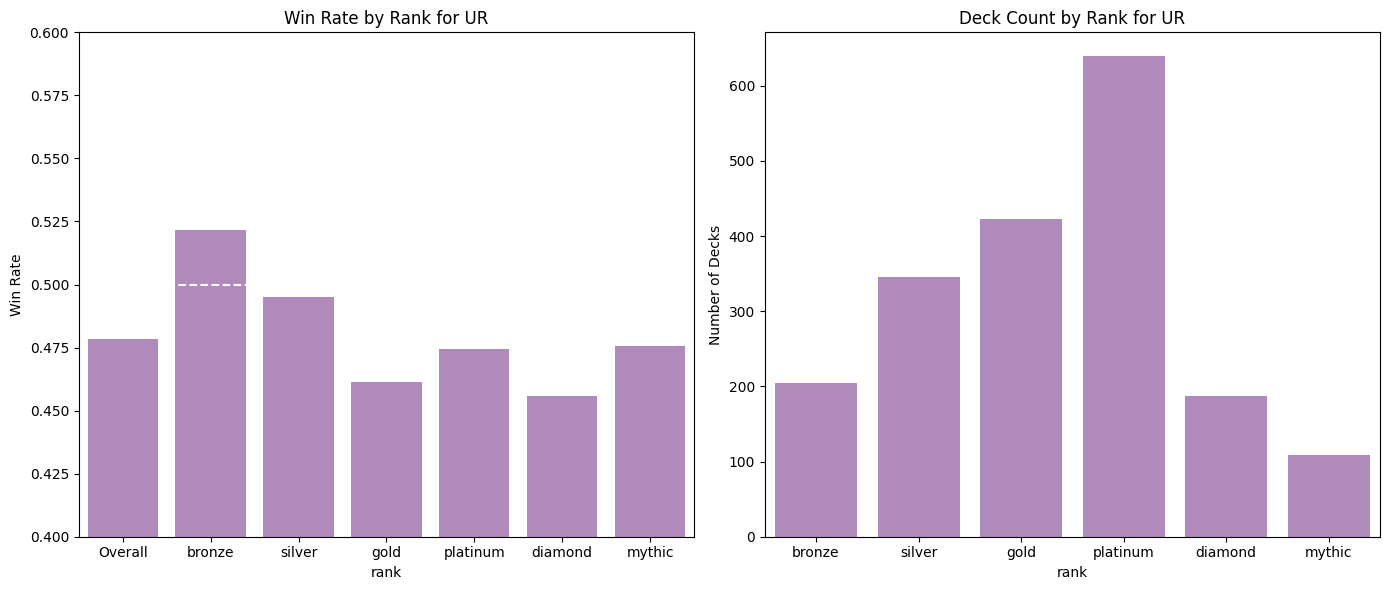

In [13]:
def plot_color_analysis(color_combo, graph_color):
    """Visualize win rate and deck count for a given color combination."""
    
    # Filter dataset for the specific color combination
    color_df = summary_df[summary_df['main_colors'] == color_combo]
    
    # Compute win rate per rank
    rank_win_rates = color_df.groupby('rank').agg(
        total_wins=('wins', 'sum'),
        total_losses=('losses', 'sum')
    ).reset_index()
    
    rank_win_rates['win_rate'] = rank_win_rates['total_wins'] / (rank_win_rates['total_wins'] + rank_win_rates['total_losses'])

    # Compute overall win rate for this color combination
    overall_win_rate = color_df['wins'].sum() / (color_df['wins'].sum() + color_df['losses'].sum())
    
    overall_df = pd.DataFrame({'rank': ['Overall'], 'win_rate': [overall_win_rate]})
    rank_win_rates = pd.concat([overall_df, rank_win_rates], ignore_index=True)

    # Compute deck count per rank
    rank_counts = color_df['rank'].value_counts().reset_index()
    rank_counts.columns = ['rank', 'count']

    # Ensure ranks are ordered correctly
    rank_order = ['Overall', 'bronze', 'silver', 'gold', 'platinum', 'diamond', 'mythic']
    rank_win_rates['rank'] = pd.Categorical(rank_win_rates['rank'], categories=rank_order, ordered=True)
    rank_counts['rank'] = pd.Categorical(rank_counts['rank'], categories=rank_order[1:], ordered=True)  # Exclude 'Overall'
    
    rank_win_rates = rank_win_rates.sort_values('rank')
    rank_counts = rank_counts.sort_values('rank')

    # Plot the graphs side by side
    _, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Win rate graph
    sns.barplot(x='rank', y='win_rate', data=rank_win_rates, color=graph_color, ax=axes[0])
    axes[0].set_title(f'Win Rate by Rank for {color_combo}')
    axes[0].set_ylim(0.4, 0.6)
    axes[0].axhline(0.5, color='white', linestyle='dashed', linewidth=1.5)
    axes[0].set_ylabel('Win Rate')

    # Deck count graph
    sns.barplot(x='rank', y='count', data=rank_counts, color=graph_color, ax=axes[1])
    axes[1].set_title(f'Deck Count by Rank for {color_combo}')
    axes[1].set_ylabel('Number of Decks')

    plt.tight_layout()
    plt.show()

plot_color_analysis('UR', '#B682C4')

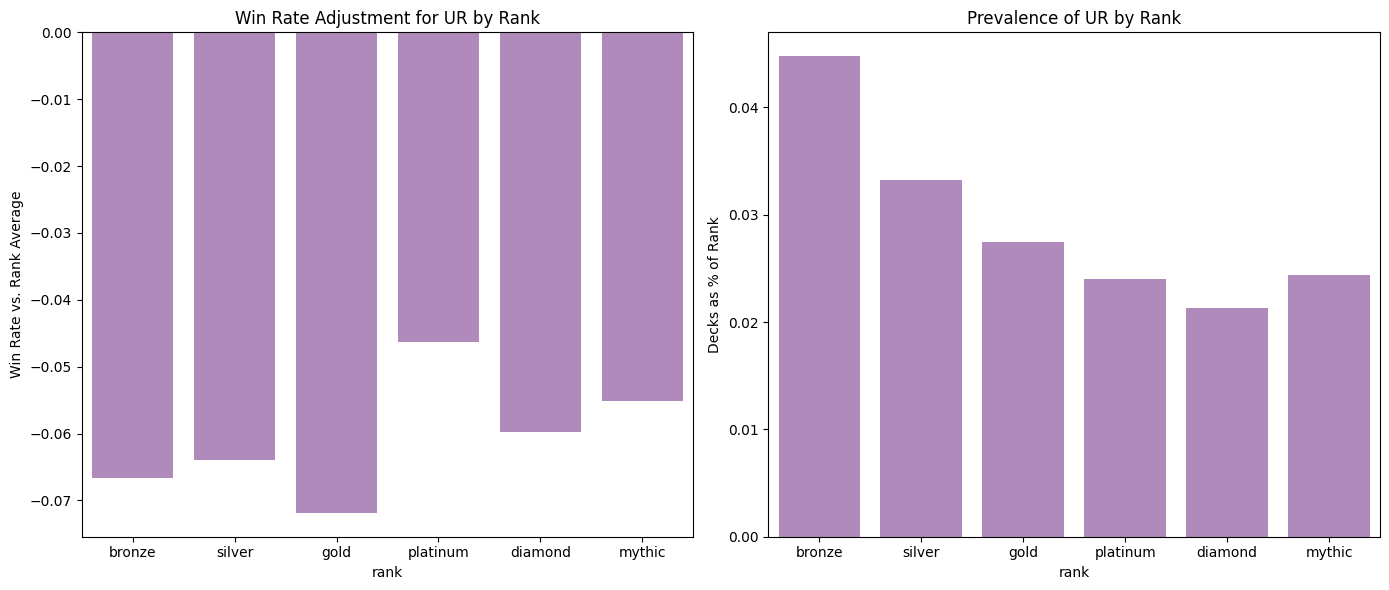

In [14]:
def normalize_color_performance(color_combo, graph_color):
    """Visualizes corrected win rate and deck prevalence for a color combo."""
    
    # Filter dataset for the specific color combination
    color_df = summary_df[summary_df['main_colors'] == color_combo]

    # Compute deck prevalence correction
    total_rank_counts = summary_df['rank'].value_counts().reset_index()
    total_rank_counts.columns = ['rank', 'total_decks']
    color_rank_counts = color_df['rank'].value_counts().reset_index()
    color_rank_counts.columns = ['rank', 'color_decks']

    rank_prevalence = pd.merge(color_rank_counts, total_rank_counts, on='rank', how='left')
    rank_prevalence['normalized_prevalence'] = rank_prevalence['color_decks'] / rank_prevalence['total_decks']

    # Compute win rate correction
    rank_win_rates = color_df.groupby('rank').agg(
        total_wins=('wins', 'sum'),
        total_losses=('losses', 'sum')
    ).reset_index()
    rank_win_rates['color_win_rate'] = rank_win_rates['total_wins'] / (rank_win_rates['total_wins'] + rank_win_rates['total_losses'])

    overall_win_rates = summary_df.groupby('rank').agg(
        total_wins=('wins', 'sum'),
        total_losses=('losses', 'sum')
    ).reset_index()
    overall_win_rates['overall_win_rate'] = overall_win_rates['total_wins'] / (overall_win_rates['total_wins'] + overall_win_rates['total_losses'])

    rank_win_correction = pd.merge(rank_win_rates, overall_win_rates[['rank', 'overall_win_rate']], on='rank', how='left')
    rank_win_correction['win_rate_adjusted'] = rank_win_correction['color_win_rate'] - rank_win_correction['overall_win_rate']

    # Ensure correct rank ordering
    rank_order = ['bronze', 'silver', 'gold', 'platinum', 'diamond', 'mythic']
    rank_prevalence['rank'] = pd.Categorical(rank_prevalence['rank'], categories=rank_order, ordered=True)
    rank_win_correction['rank'] = pd.Categorical(rank_win_correction['rank'], categories=rank_order, ordered=True)

    rank_prevalence = rank_prevalence.sort_values('rank')
    rank_win_correction = rank_win_correction.sort_values('rank')

    # Plot the graphs side by side (Win Rate on the Left, Prevalence on the Right)
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Win rate correction graph (left)
    sns.barplot(x='rank', y='win_rate_adjusted', data=rank_win_correction, color=graph_color, ax=axes[0])
    axes[0].set_title(f'Win Rate Adjustment for {color_combo} by Rank')
    axes[0].axhline(0, color='white', linestyle='dashed', linewidth=1.5)  # Baseline at 0 (neutral performance)
    axes[0].set_ylabel('Win Rate vs. Rank Average')

    # Prevalence graph (right)
    sns.barplot(x='rank', y='normalized_prevalence', data=rank_prevalence, color=graph_color, ax=axes[1])
    axes[1].set_title(f'Prevalence of {color_combo} by Rank')
    axes[1].set_ylabel('Decks as % of Rank')

    plt.xticks()
    plt.tight_layout()
    plt.show()

normalize_color_performance('UR', '#B682C4')

##### Color/Rank Note

![Blue red otter](images/otter_small.png)

The blue/red otters deck is generally recognized as one of the weaker choices; looking at it by rank confirms that it's not merely a high-skill deck that less-experienced players struggle with. Let's hop over to look at a stronger archetype.

![Green white rabbit](images/rabbit2.png)

Follow the green and white rabbit, Neo (and the squirrel).

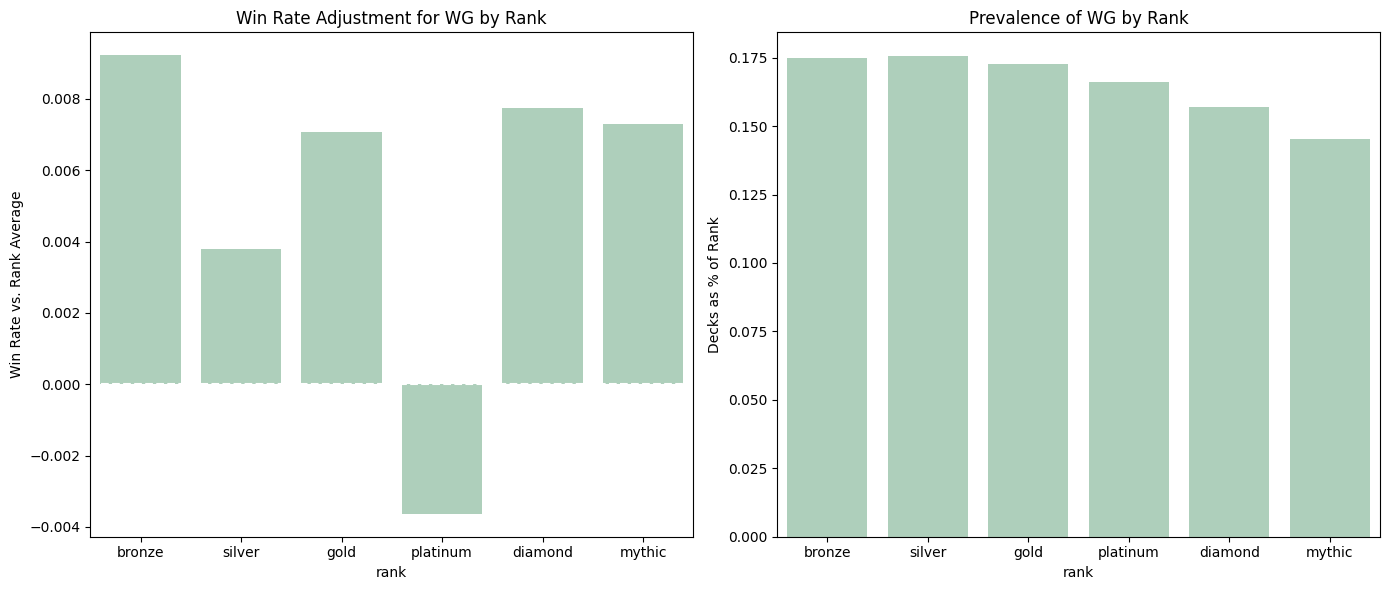

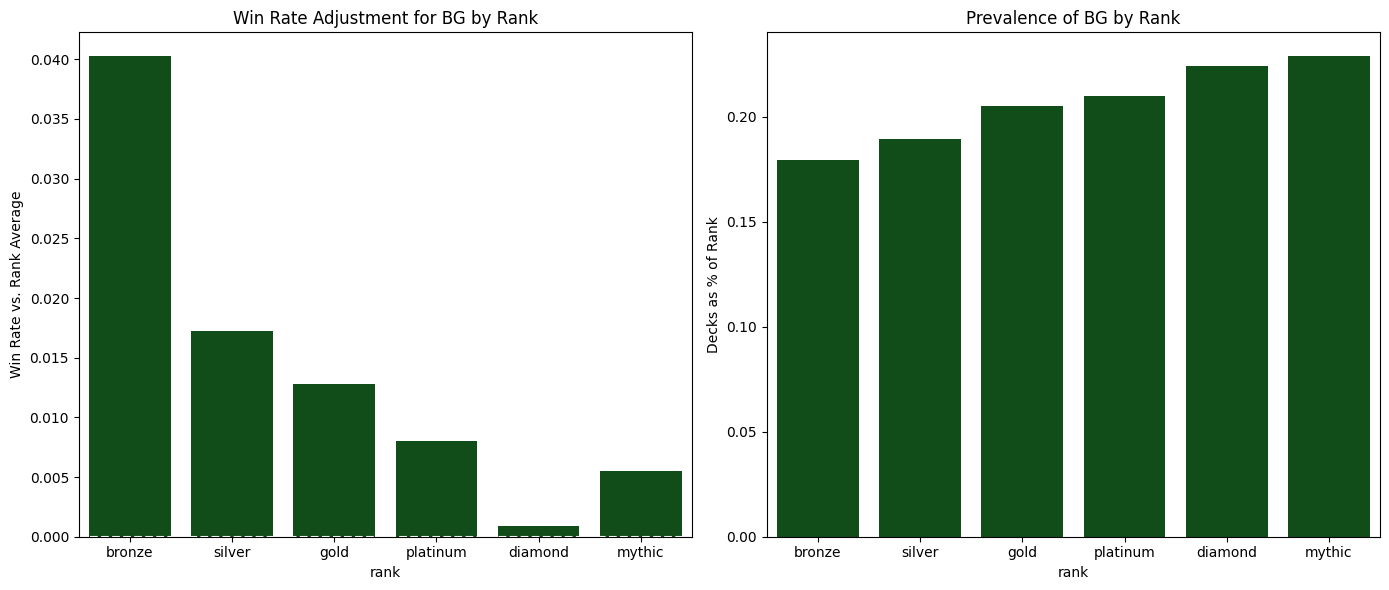

In [15]:
normalize_color_performance('WG', '#A8D5BA')
normalize_color_performance('BG', "#075712")

#### Bloomburrow Decks EDA Conclusion

We've looked at some of the archetypes, examining normalized results by ranking. Note the **very** different scales on the Y axes above (it *looks* like there's a big swing on rabbits from gold to platinum, but all values are close to 0).

### Bloomburrow Cards EDA

Next we'll take a look at the much smaller data set of card information.

In [17]:
def get_card_data(set_code: str) -> pd.DataFrame:
    """Fetches Scryfall data for a specific set and saves it to a CSV file.
    If the CSV already exists, it loads the data from there instead of fetching it again.

    This data is paginated, so it will fetch all pages until no more data is available.

    Set codes: https://en.wikipedia.org/wiki/List_of_Magic:_The_Gathering_sets

    e.g Bloomburrow = "blb"
    """

    # Check if the CSV file exists
    file_path = f"data/{set_code}/cards.csv"
    if os.path.exists(file_path):
        print(f"Loading Scryfall data for {set_code} from existing file...")
        df = pd.read_csv(file_path)
        return df
    
    # If not, fetch the data from Scryfall API
    print(f"Fetching Scryfall API data for {set_code}...")
    os.makedirs(os.path.dirname(file_path), exist_ok=True)  # Ensure the directory exists
    url = f"https://api.scryfall.com/cards/search?q=set:{set_code}"
    all_data = []  

    while url:
        response = requests.get(url)
        response_data = response.json()
        
        all_data.extend(response_data["data"])
        
        # Check if there are more pages
        url = response_data.get("next_page", None)  # Fetch next page if available

    # Convert full dataset to DataFrame and save
    df = pd.DataFrame(all_data)
    df.set_index("name", inplace=True)
    df.to_csv(file_path, index=False)
    return df

In [18]:
blb_df = get_card_data("blb")
blb_df.head(2)

Loading Scryfall data for blb from existing file...


,object,id,oracle_id,multiverse_ids,mtgo_id,arena_id,tcgplayer_id,cardmarket_id,name,lang,...,related_uris,purchase_uris,power,toughness,all_parts,security_stamp,promo_types,frame_effects,produced_mana,loyalty
0,card,7dd9946b-515e-4e0d-9da2-711e126e9fa6,7b89b7d2-c724-4d5d-9f0b-7d3302ad1168,[669036],129489.0,91658.0,559491.0,778435.0,Agate Assault,en,...,{'gatherer': 'https://gatherer.wizards.com/Pag...,{'tcgplayer': 'https://partner.tcgplayer.com/c...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,card,39ebb84a-1c52-4b07-9bd0-b360523b3a5b,381a3e8e-71dd-48e4-ab62-53478bde4a14,[668996],129409.0,91618.0,559647.0,778511.0,Agate-Blade Assassin,en,...,{'gatherer': 'https://gatherer.wizards.com/Pag...,{'tcgplayer': 'https://partner.tcgplayer.com/c...,1,3,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
core_card_data = ["name", "mana_cost", "cmc", "type_line", "oracle_text", "colors", "color_identity", "keywords", "rarity", "power", "toughness"]
skeptical_keepers = ["reprint"]
external_references = ["oracle_id", "multiverse_ids", "mtgo_id", "arena_id", "tcgplayer_id", "cardmarket_id"]
status_and_printing = ["foil", "nonfoil", "promo", "variation", "security_stamp", "frame", "full_art", "textless"]
art_and_flavor = ["artist", "illustration_id", "flavor_text", "border_color"]
marketplace_and_pricing = ["purchase_uris", "related_uris"]
metadata_and_links = ["set", "set_name", "set_type", "set_uri", "set_search_uri", "scryfall_set_uri", "rulings_uri", "prints_search_uri", "collector_number"]

drop_list = external_references + status_and_printing + art_and_flavor + marketplace_and_pricing + metadata_and_links

blb_df = blb_df.drop(columns=drop_list, errors='ignore')
blb_df.shape
blb_df.columns

Index(['object', 'id', 'name', 'lang', 'released_at', 'uri', 'scryfall_uri',
       'layout', 'highres_image', 'image_status', 'image_uris', 'mana_cost',
       'cmc', 'type_line', 'oracle_text', 'colors', 'color_identity',
       'keywords', 'legalities', 'games', 'reserved', 'game_changer',
       'finishes', 'oversized', 'reprint', 'set_id', 'digital', 'rarity',
       'card_back_id', 'artist_ids', 'booster', 'story_spotlight',
       'edhrec_rank', 'penny_rank', 'preview', 'prices', 'power', 'toughness',
       'all_parts', 'promo_types', 'frame_effects', 'produced_mana',
       'loyalty'],
      dtype='object')

In [20]:
#useless
adtl_droplist = ['object', 'id', 'uri', 'scryfall_uri', 'highres_image', 'image_status',
                 'image_uris', 'reserved', # reserved would be useful but all false
                 'finishes', 'oversized', 'set_id', 'digital', 'card_back_id', 
                 'artist_ids', 'games', 'story_spotlight',
                 'legalities', #theoretically useful to know if a card has been banned,
                 'edhrec_rank', # Theoretically useful
                 'loyalty', # starting 'health' of planeswalkers, only one in the set =4
                 'promo_types', 'all_parts', 'frame_effects', 'lang', 'preview',
                 'released_at', 
                 ]

#maybe
next_drop = []


#useful to clean up rows?
row_cleanup_cols = [
                    'booster', # if false drop
                    ]

blb_df = blb_df.drop(columns=adtl_droplist, errors='ignore')
blb_df.columns

Index(['name', 'layout', 'mana_cost', 'cmc', 'type_line', 'oracle_text',
       'colors', 'color_identity', 'keywords', 'game_changer', 'reprint',
       'rarity', 'booster', 'penny_rank', 'prices', 'power', 'toughness',
       'produced_mana'],
      dtype='object')

In [21]:
# Reset the index, turning 'name' into a regular column
if blb_df.index.name == 'name':
    blb_df = blb_df.reset_index()
    print("Index 'name' was reset and converted to a regular column.")
#blb_df['produced_mana'].value_counts()

further_drop = ['layout', #layout is just the "Talent" cards
                'game_changer', #theoretically should be useful, but all false
                ]

blb_df = blb_df.drop(columns=further_drop, errors='ignore')
blb_df.head()

,name,mana_cost,cmc,type_line,oracle_text,colors,color_identity,keywords,reprint,rarity,booster,penny_rank,prices,power,toughness,produced_mana
0,Agate Assault,{2}{R},3.0,Sorcery,Choose one —\n• Agate Assault deals 4 damage t...,['R'],['R'],[],False,common,True,13345.0,"{'usd': '0.03', 'usd_foil': '0.06', 'usd_etche...",NaN,NaN,NaN
1,Agate-Blade Assassin,{1}{B},2.0,Creature — Lizard Assassin,"Whenever this creature attacks, defending play...",['B'],['B'],[],False,common,True,NaN,"{'usd': '0.03', 'usd_foil': '0.07', 'usd_etche...",1,3,NaN
2,A-Heartfire Hero,{R},1.0,Creature — Mouse Soldier,Valiant — Whenever Heartfire Hero becomes the ...,['R'],['R'],['Valiant'],False,uncommon,False,NaN,"{'usd': None, 'usd_foil': None, 'usd_etched': ...",0,1,NaN
3,"Alania, Divergent Storm",{3}{U}{R},5.0,Legendary Creature — Otter Wizard,"Whenever you cast a spell, if it's the first i...","['R', 'U']","['R', 'U']",[],False,rare,True,NaN,"{'usd': '0.08', 'usd_foil': '0.20', 'usd_etche...",3,5,NaN
4,Alania's Pathmaker,{3}{R},4.0,Creature — Otter Wizard,"When this creature enters, exile the top card ...",['R'],['R'],[],False,common,True,NaN,"{'usd': '0.02', 'usd_foil': '0.06', 'usd_etche...",4,2,NaN


In [22]:
# drop cards not appearing in boosters, then drop that col

if 'booster' in blb_df.columns.values:
    blb_df = blb_df[blb_df['booster'] == True]
    blb_df =  blb_df.drop(columns='booster', errors='ignore')

blb_df.columns

Index(['name', 'mana_cost', 'cmc', 'type_line', 'oracle_text', 'colors',
       'color_identity', 'keywords', 'reprint', 'rarity', 'penny_rank',
       'prices', 'power', 'toughness', 'produced_mana'],
      dtype='object')

Remaining fields explained:

* **`name`**: The full name of the Magic: The Gathering card.
* **`mana_cost`**: The mana symbols representing the cost to cast the card (e.g., `{1}{U}{U}`).
* **`cmc`**: Converted Mana Cost; the total amount of mana in the cost, regardless of color (e.g., `{1}{U}{U}` has a CMC of 3).
* **`type_line`**: The card's type, supertype, and subtype (e.g., "Legendary Creature — Human Knight", "Instant").
* **`oracle_text`**: The official, comprehensive rules text of the card.
* **`colors`**: The color(s) of the card, derived from its mana cost or color indicator (e.g., `['U']` for blue, `['W', 'B']` for white/black).
* **`color_identity`**: The card's colors (a bit complicated; only matters in other formats)
* **`keywords`**: A list of keyword abilities the card has (e.g., `['Flying', 'Haste']`).
* **`reprint`**: Whether a card is reprinted vs new in this set
* **`rarity`**: The card's rarity (e.g., "common", "uncommon", "rare", "mythic").
* **`penny_rank`**: Rank/popularity in Penny Dreadful decks (a specific format).
* **`prices`**: List of prices, about to be converted
* **`power`**: For creature cards, its attack value (e.g., "2", or "*" for variable power). `NaN` for non-creatures.
* **`toughness`**: For creature cards, its defense value (e.g., "3", or "*" for variable toughness). `NaN` for non-creatures.
* **`produced_mana`**: The mana symbols that a permanent can produce (e.g., `['U']` for a land that taps for blue mana).

All of these fields except rarity and penny_rank affect the play of the game. We're holding on to those because they may be good indicators of card power.

In [25]:
if 'prices' in blb_df.columns:
    # Check if the 'price' column already exists. If it does, and 'prices' is already gone,
    # it means the operation was already completed.
    if 'price' in blb_df.columns and 'prices' not in blb_df.columns:
        print("The 'price' column already exists and 'prices' has been dropped. Operation is idempotent.")
    else:
        print("Converting 'prices' column to 'price' (USD).")

        # Helper function to safely extract the USD price
        # Handles NaN/None input, and potential errors during literal_eval or float conversion
        def extract_usd_price_idempotent(price_dict_str):
            if pd.isna(price_dict_str): # Check for NaN/None directly from Pandas
                return None
            try:
                # Safely evaluate the string representation of a dictionary
                price_dict = ast.literal_eval(str(price_dict_str)) # Convert to string first for robustness
                
                # Get the 'usd' value, defaulting to None if the key is missing
                usd_val = price_dict.get('usd')
                
                # Convert to float. If usd_val is None or cannot be converted, return None.
                return float(usd_val) if usd_val is not None else None
            except (ValueError, SyntaxError, TypeError):
                # Catch errors if the string isn't a valid dictionary or conversion fails
                return None

        # Apply the conversion to create the new 'price' column
        blb_df['price'] = blb_df['prices'].apply(extract_usd_price_idempotent)

        # Drop the original 'prices' column after conversion
        # Using errors='ignore' ensures it doesn't fail if 'prices' somehow got dropped prematurely
        blb_df = blb_df.drop(columns=['prices'], errors='ignore')

        print("Conversion complete. 'prices' column dropped, 'price' column added.")

Converting 'prices' column to 'price' (USD).
Conversion complete. 'prices' column dropped, 'price' column added.


In [26]:
# only 5 non-reprints
blb_df[blb_df['reprint'] == True].head()

,name,mana_cost,cmc,type_line,oracle_text,colors,color_identity,keywords,reprint,rarity,penny_rank,power,toughness,produced_mana,price
9,Banishing Light,{2}{W},3.0,Enchantment,"When this enchantment enters, exile target non...",['W'],['W'],[],True,common,809.0,NaN,NaN,NaN,0.03
69,Fabled Passage,NaN,0.0,Land,"{T}, Sacrifice this land: Search your library ...",[],[],[],True,rare,NaN,NaN,NaN,NaN,5.08
188,Run Away Together,{1}{U},2.0,Instant,Choose two target creatures controlled by diff...,['U'],['U'],[],True,common,13892.0,NaN,NaN,NaN,0.05
207,Shore Up,{U},1.0,Instant,Target creature you control gets +1/+1 and gai...,['U'],['U'],[],True,common,2849.0,NaN,NaN,NaN,0.08
255,Uncharted Haven,NaN,0.0,Land,"This land enters tapped. As it enters, choose ...",[],[],[],True,common,8811.0,NaN,NaN,"['B', 'G', 'R', 'U', 'W']",0.04


##### Price Note

Why price is not a great indicator: certain cards do not add that much value to a limited deck, but are quite in demand in other formats. Fabled Passage (~$4.74) is a perfect example. It's not a **bad** card for a draft deck, by any means, but in a lot of decks you'd rather have Banishing Light (~$0.04). (Price values change over time)

### Card EDA Dive

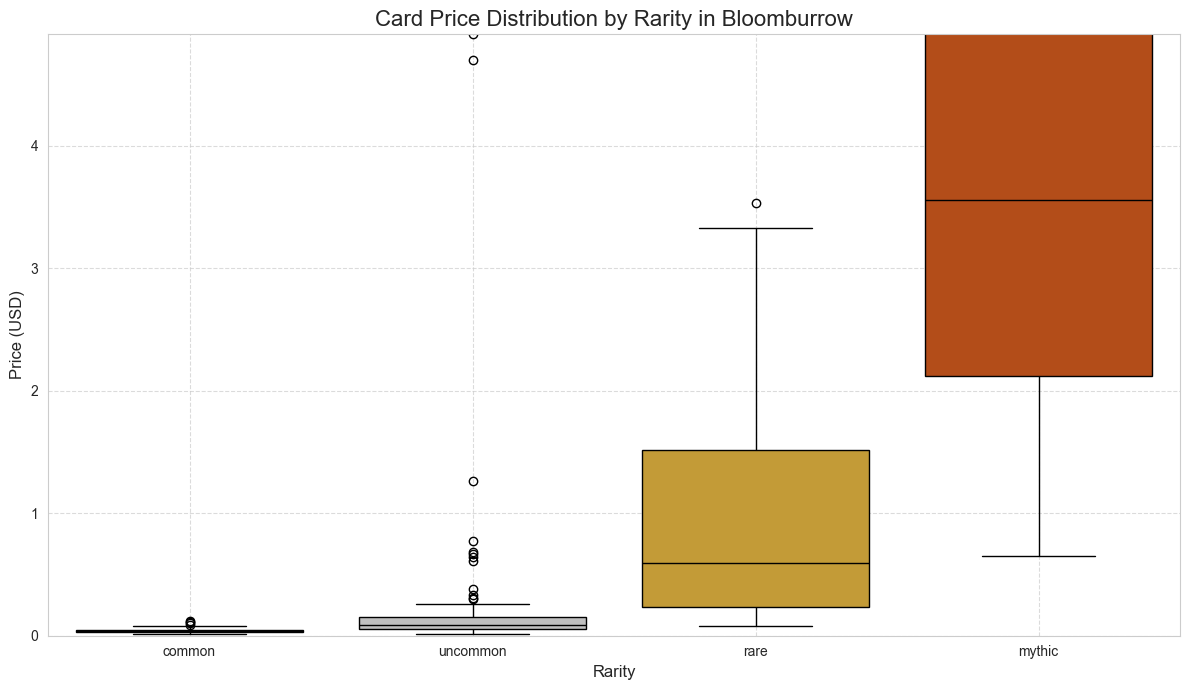

In [27]:
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6) # Default figure size


blb_df['price'] = pd.to_numeric(blb_df['price'], errors='coerce')

# Define the standard MTG rarity order for consistent plotting
rarity_order = ['common', 'uncommon', 'rare', 'mythic']
blb_df['rarity'] = pd.Categorical(blb_df['rarity'], categories=rarity_order, ordered=True)

# --- Define custom rarity colors based on MTG symbol structure (Adjusted) ---
rarity_colors = {
    'common': '#000000',
    'uncommon': '#C0C0C0',
    'rare': '#DAA520',
    'mythic': '#CC4400'
}

plt.figure(figsize=(12, 7))

# Apply the custom color palette to the box plot and fix the FutureWarning
sns.boxplot(x='rarity', y='price', data=blb_df, palette=rarity_colors, hue='rarity', legend=False)

plt.title('Card Price Distribution by Rarity in Bloomburrow', fontsize=16)
plt.xlabel('Rarity', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
# Limit y-axis to focus on the bulk of data (e.g., up to the 95th percentile)
plt.ylim(0, blb_df['price'].quantile(0.95))
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

##### Price Distributions

That's a bit rough to read, but we can clearly see strong patterns. Commons max out around 10c. A few good uncommon cards retain some value. Mythic rares clearly are the most expensive, but still contain some "bulk mythics" ("bulk rares" and rare cards worth less than $1).

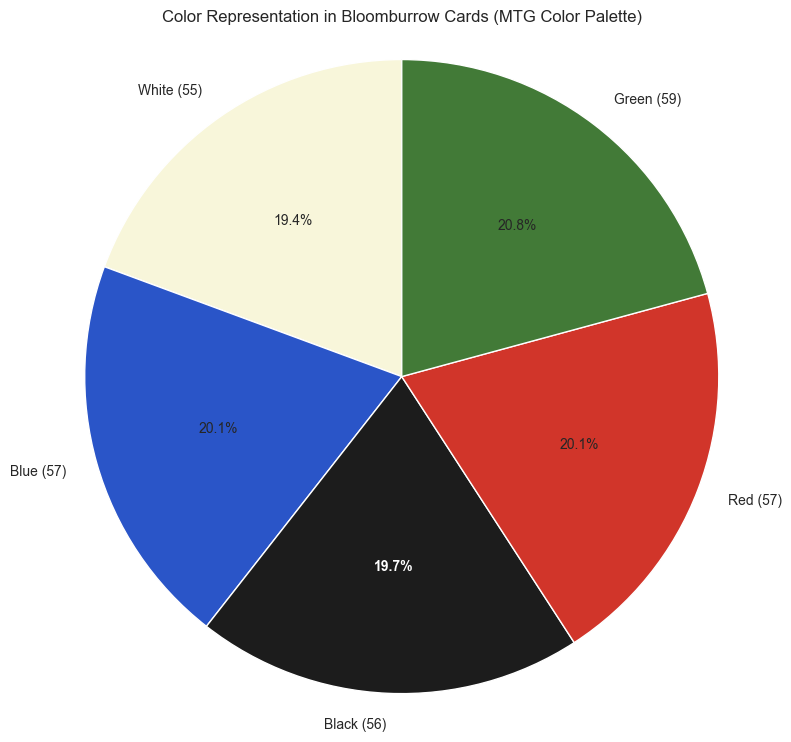

In [28]:
# Preprocessing for colors: Flatten the list of lists and count occurrences
all_colors = []
# Iterate through the 'colors' column, handling NaNs and ensuring list type
for card_colors in blb_df['colors'].dropna():
    if isinstance(card_colors, list):
        all_colors.extend(card_colors)
    elif isinstance(card_colors, str):
        try:
            # Try to convert string representation of list
            parsed_colors = ast.literal_eval(card_colors)
            if isinstance(parsed_colors, list):
                all_colors.extend(parsed_colors)
            else:
                # Handle cases where it's a single color string 'U' not ['U']
                all_colors.append(parsed_colors) 
        except (ValueError, SyntaxError):
            # If it's just a single color code like 'U' and not a list string
            all_colors.append(card_colors) # Add as is, assuming it's a color code

# Add 'Colorless' category for cards with empty 'colors' list/NaN
colorless_count = blb_df['colors'].apply(lambda x: len(x) == 0 if isinstance(x, list) else (pd.isna(x))).sum()
color_counts = pd.Series(all_colors).value_counts()

# Add 'Colorless' to the counts
if colorless_count > 0:
    color_counts['Colorless'] = color_counts.get('Colorless', 0) + colorless_count

# Sort colors for consistent pie chart ordering (WUBRG + Colorless/Multi)
# Define standard MTG color order
mtg_color_order = ['W', 'U', 'B', 'R', 'G', 'Colorless'] 
# Filter color_counts to only include keys in mtg_color_order, then reindex
color_counts_ordered = color_counts.reindex(mtg_color_order, fill_value=0)
# Add any other colors that might be present (e.g. if multi-color was included directly in 'colors')
for color in color_counts.index:
    if color not in mtg_color_order:
        color_counts_ordered[color] = color_counts[color]
        
mtg_color_full_names = {
    'W': 'White',
    'U': 'Blue',
    'B': 'Black',
    'R': 'Red',
    'G': 'Green',
    'Colorless': 'Colorless',
}

# --- Define the MTG Custom Color Palette ---
mtg_colors_palette = {
    'W': '#F8F6DA',  # White (often represented as a creamy or light beige)
    'U': '#2A55C8',  # Blue (a classic, deep magic blue)
    'B': '#1C1C1C',  # Black (very dark grey or off-black)
    'R': '#D1352A',  # Red (a vibrant, fiery red)
    'G': '#427A37',  # Green (a rich, earthy green)
    'Colorless': '#A0A0A0', # A neutral grey for colorless cards
    # If you were to explicitly categorize 'Multicolor' cards as one group:
    # 'Multicolor': '#DAA520' # Gold
}

mtg_color_order = ['W', 'U', 'B', 'R', 'G', 'Colorless'] 

# Create an ordered Series of counts, filtering for colors present in the data and our palette
color_counts_ordered = color_counts.reindex(mtg_color_order, fill_value=0)

# Filter out colors that have 0 count to avoid empty slices and ensure correct labels/colors alignment
# Also, ensure only colors explicitly in our `mtg_colors_palette` are considered
present_colors_in_order = [
    color for color in mtg_color_order 
    if color_counts_ordered.get(color, 0) > 0 and color in mtg_colors_palette
]

counts_for_pie = color_counts_ordered[present_colors_in_order]

# Get the corresponding colors from our custom palette
colors_for_pie = [mtg_colors_palette[color] for color in present_colors_in_order]

# Percent and count labels
# Create labels for the pie chart using full color names and counts
labels_for_pie = [
    f"{mtg_color_full_names[color_abbr]} ({count})"
    for color_abbr, count in counts_for_pie.items()
]

plt.figure(figsize=(9, 9))
wedges, texts, autotexts = plt.pie(
    counts_for_pie,
    labels=labels_for_pie,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors_for_pie
)

black_index = present_colors_in_order.index('B')
autotexts[black_index].set_color('white')
autotexts[black_index].set_weight('bold') # Optional: makes it bolder for contrast

plt.title('Color Representation in Bloomburrow Cards (MTG Color Palette)')
plt.axis('equal')
plt.show()


It's very much expected for this to be relatively even, as this is a balance issue. Also multi-color cards are counted twice.

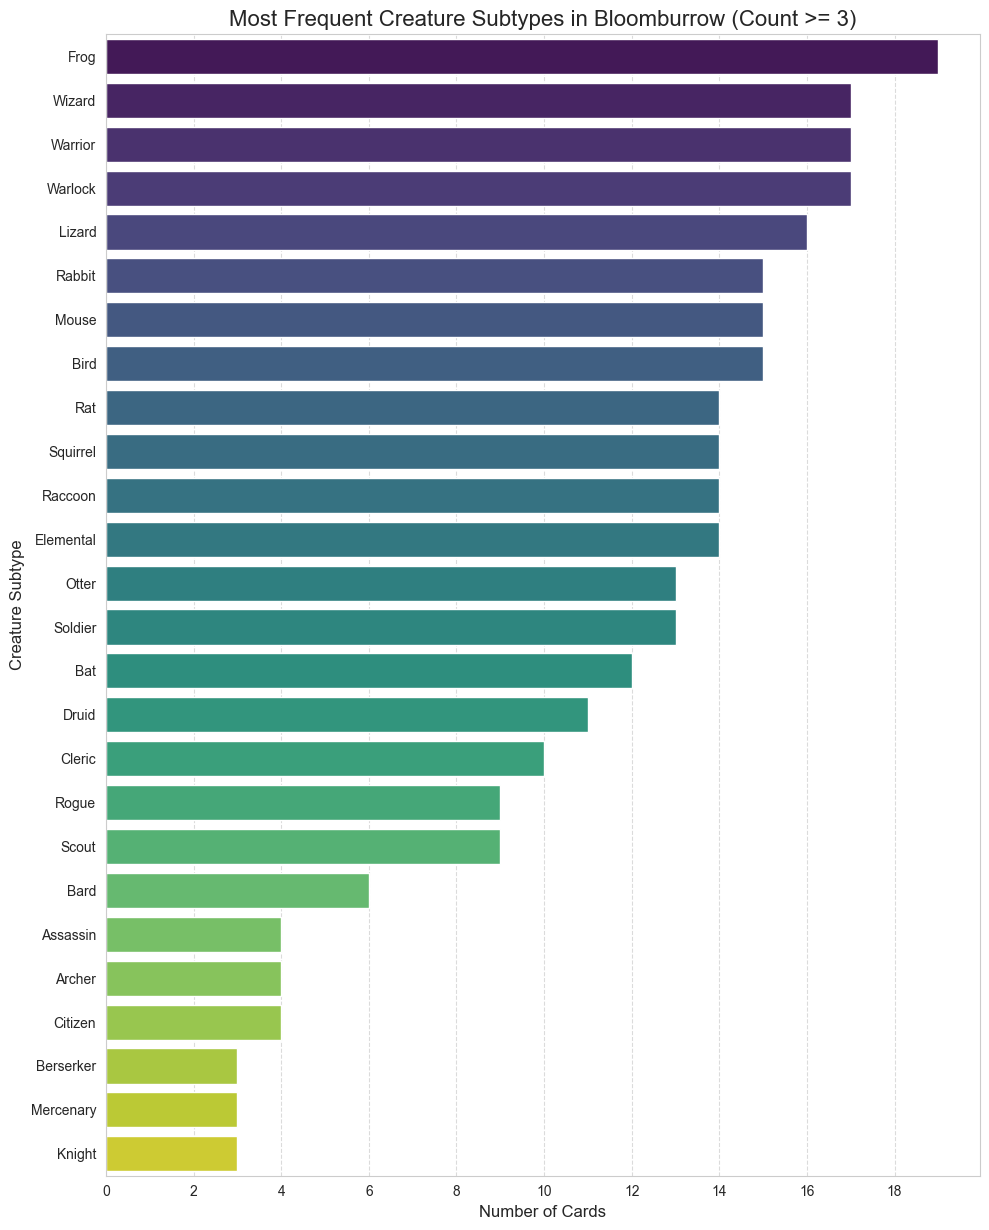

In [31]:
# Get a list of all creature types
creature_subtypes = []
for type_line in blb_df['type_line'].dropna():
    if 'Creature' in type_line:
        # Subtypes occur after the dash
        subtypes_part = type_line.split('—')[1].strip()
        current_subtypes = [s.strip() for s in subtypes_part.split(' ') if s.strip()]
        creature_subtypes.extend(current_subtypes)

subtype_counts = Counter(creature_subtypes)

# Filter out types with fewer than 3 occurrences
filtered_subtypes = {subtype: count for subtype, count in subtype_counts.items() if count >= 3}

# Put most common subtypes first
sorted_subtypes = sorted(filtered_subtypes.items(), key=lambda item: item[1], reverse=True)

# Extract labels (subtype names) and values (counts)
labels = [item[0] for item in sorted_subtypes]
values = [item[1] for item in sorted_subtypes]

plt.figure(figsize=(10, len(labels) * 0.4 + 2)) # Dynamic height based on number of labels, with a min height
sns.barplot(x=values, y=labels, hue=labels, palette='viridis', legend=False, order=labels)

plt.title('Most Frequent Creature Subtypes in Bloomburrow (Count >= 3)', fontsize=16)
plt.xlabel('Number of Cards', fontsize=12)
plt.ylabel('Creature Subtype', fontsize=12)
plt.xticks(fontsize=10)
plt.gca().xaxis.set_major_locator(mticker.MaxNLocator(integer=True)) # Ensure integer ticks
plt.yticks(fontsize=10)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Understanding the Bloomburrow Dataset

This project analyzes data from **Bloomburrow**, a Magic: The Gathering set uniquely focused on anthropomorphic animal characters. This design significantly shapes the creature types and color distributions we observe.

A core structural element of Bloomburrow is its **"Tribes"**: ten distinct animal species, each inherently tied to a specific two-color combination. These tribes serve as the set's primary **archetypes**. In the context of a card game, an **archetype** represents a defined strategic identity or playstyle. It's a blueprint for how cards are designed to interact and function together within a specific framework.

For players, "picking a tribe" means embracing a particular archetype, leading to specific card synergies and gameplay strategies. For set designers (and our data analysis), this tribal structure ensures cards are deliberately crafted to support these distinct groupings. This strong internal consistency within the tribes directly impacts the clusters and patterns of abilities, keywords, and overall card characteristics we see in our dataset.

The ten primary tribes and their associated two-color identities are:

* **Birds:** White-Blue (WU) - Flying/non-flying synergies
* **Rats:** Blue-Black (UB) - Threshold/graveyard mechanics
* **Lizards:** Black-Red (BR) - Opponent life loss
* **Raccoons:** Red-Green (RG) - Expend (Spending 4 or more mana)
* **Rabbits:** Green-White (GW) - Offspring/Abundance/tokens
* **Bats:** White-Black (WB) - Life gain/life loss
* **Otters:** Blue-Red (UR) - Non-creature spells
* **Squirrels:** Black-Green (BG) - Forage/graveyard mechanics
* **Mice:** Red-White (RW) - Valiant/fast aggression
* **Frogs:** Green-Blue (GU) - "Blink" mechanics

The patterns in our data, such as creature type prevalence and color usage, directly reflect these foundational design principles and the strategic roles of each Bloomburrow tribe.

---
Summary prepared by Gemini, edited.

#### Deeper Tribe Descriptions

For those who are interested and familiar with general MTG mechanics/concepts, we have prepared a deeper dive into these tribes. We'll describe the basic strategy of the deck, and provide a subjective evaluation of its relative strength in the meta. In draft, finding an 'open lane' is often more valuable than fighting over the strongest archetype. Rabbits are a very strong tribe, but if 3 people at the table are trying to draft them, none of those 3 people will do well. This effect inherently balances out the "weaker" tribes.

* **Birds:** Focuses on synergies between flying creatures and non-flying creatures; requires a good mix of both to succeed. Looks to close out the game with evasive creatures.
    - Tier: Mid/low
    - Bomb: Kastral, the Windcrested
    - Notable commons/uncommons: Plumecreed Escort (U), Plumecreed Mentor (U)
* **Rats:** Graveyard synergies, using Surveil to trigger Threshold. Relies on high-performing uncommons
    - Tier: Mid
    - Bomb: Vren, the Relentless
    - Notable commons/uncommons: **Shoreline Looter** (U), **Persistent Marshstalker** (U), Mindwhisker (U)
* **Lizards:** Aggressive deck that powers up creatures based on opponent life loss. All-in on aggression.
    - Tier: Mid
    - Bomb: **Gev, Scaled Scorch**, Hired Claw, Iridescent Vinelasher
    - Notable commons/uncommons: Flamecache Gecko (U), Thought-Stalker Warlock (U)
* **Raccoons:** Midrange deck; requires careful mana management to trigger expend.
    - Tier: Mid/low
    - Bomb: Keen-Eyed Curator, Scrapshooter
    - Notable commons/uncommons: Roughshod Duo (C), Bakersbane Duo (C), Teapot Slinger(U), Bark-Knuckle Boxer (U)
* **Rabbits:** Strength in numbers; focused on overwhelming opponents with many creature tokens. Many strong commons/uncommons.
    - Tier: Top (best)
    - Bomb: **Warren Warleader**, Pawpatch Recruit
    - Notable commons/uncommons: **Intrepid Rabbit** (C), Warren Elder (C), Head of the Homestead (C), Harvestrite Host (U)
* **Bats:** Life gain/loss synergies and evasion (flying). Aims to stall the game and grind out victory.
    - Tier: Top/mid
    - Bomb: Darkstar Augur; Essence Channeler; Zoraline, Cosmos Caller
    - Notable commons/uncommons: **Lifecreed Duo** (C), Starscape Cleric (U)
* **Otters:** Focused on non-creature spell synergies; requires a careful mix to succeed. Easy to flop.
    - Tier: Low
    - Bomb: Bria, Riptide Rogue
    - Notable commons/uncommons: Coruscation Mage (U), Tempest Angler (C)
* **Squirrels:** Graveyard synergies, midrange aggression, grinding efficiency. Forage and Food.
    - Tier: Top
    - Bomb: Camellia, the Seedmiser; Ygra, Eater of All
    - Notable commons/uncommons: Bakersbane Duo (C), Bushy Bodyguard (U), Curious Forager (U), **Vinereap Mentor** (U)
* **Mice:** Valiant keyword; needs a good mix of Valiant cards and enablers. Fast, all-in aggression.
    - Tier: Top
    - Bomb: Emberheart Challenger; Mabel, Heir to Cragflame; Manifold Mouse
    - Notable commons/uncommons: Intrepid Rabbit (C), **Heartfire Hero** (U)
* **Frogs:** Blink creatures in and out of play to abuse ETB abilities; "bouncy" theme. Mid-range.
    - Tier: Top/mid
    - Bomb: Clement, the Worrywort; Dreamdew Entrancer
    - Notable commons/uncommons: Stickytongue Sentinal (C), Pond Prophet (C), Three Tree Scribe (U), Long River Lurker (U)

Keep in mind that these are general descriptions; it's possible to have a Bat or Frog deck focused on early aggression, or a more mid-game focused Lizard deck. All tribes can be strong with the right cards. The "Duo" cards belong to two tribes; some creatures are so good outside their tribe they show up in other decks (Intrepid Rabbit).

In [32]:
# Lands are the only 0 cmc
blb_df['name'][blb_df['cmc'] == 0.0].values

array(['Fabled Passage', 'Fountainport', 'Hidden Grotto',
       'Lilypad Village', 'Lupinflower Village', 'Mudflat Village',
       'Oakhollow Village', 'Rockface Village', 'Three Tree City',
       'Uncharted Haven'], dtype=object)

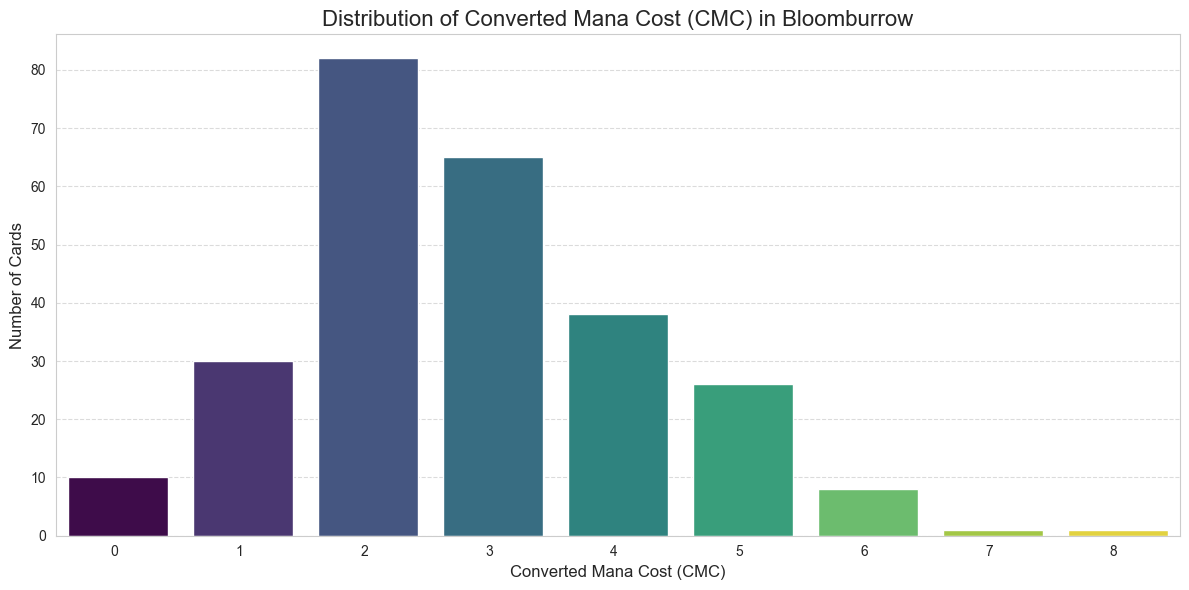

In [33]:
# CMC Distribution
cmc_counts = blb_df['cmc'].dropna().value_counts().sort_index()

plt.figure(figsize=(12, 6))
sns.barplot(x=cmc_counts.index, y=cmc_counts.values, hue=cmc_counts.index, palette='viridis', legend=False)

plt.title('Distribution of Converted Mana Cost (CMC) in Bloomburrow', fontsize=16)
plt.xlabel('Converted Mana Cost (CMC)', fontsize=12)
plt.ylabel('Number of Cards', fontsize=12)

plt.xticks(ha='right', fontsize=10) # Keep rotation and font size

# Use a locator for integer positions and a formatter for integer display
plt.gca().xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%d')) # Format as integer

plt.yticks(fontsize=10)

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

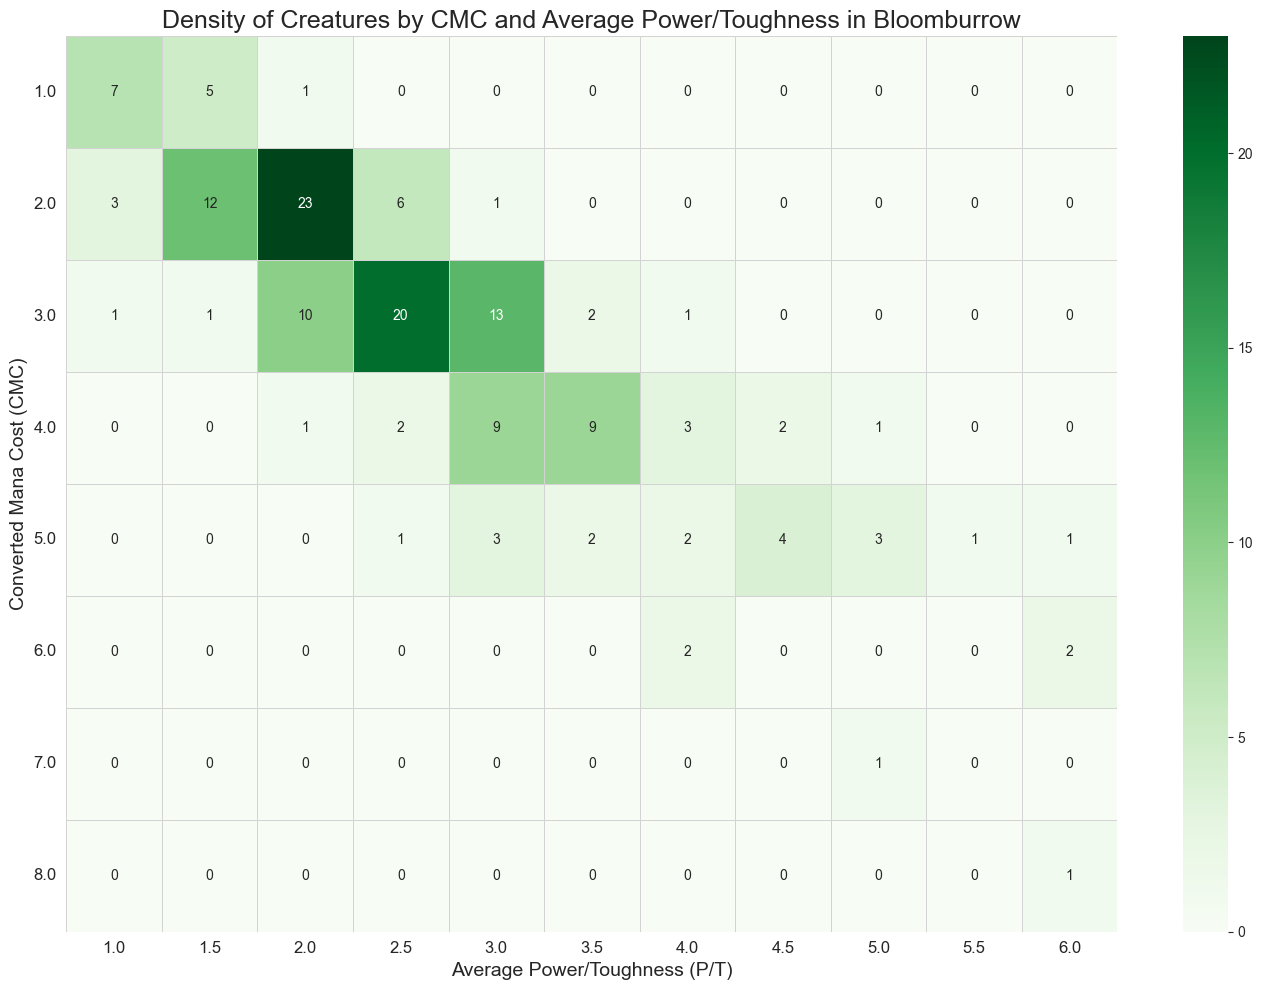

In [34]:
creatures_df = blb_df[blb_df['type_line'].str.contains('Creature', na=False)].copy()

# Define a helper function to safely convert P/T strings to floats.
# It handles non-numeric values (like '*' or '-') by converting them to NaN.
def convert_pt_to_numeric(pt_str):
    try:
        return float(pt_str)
    except (ValueError, TypeError):
        return np.nan # Return NaN for non-numeric P/T (e.g., '*')

creatures_df['numeric_power'] = creatures_df['power'].apply(convert_pt_to_numeric)
creatures_df['numeric_toughness'] = creatures_df['toughness'].apply(convert_pt_to_numeric)

creatures_df['avg_pt'] = (creatures_df['numeric_power'] + creatures_df['numeric_toughness']) / 2

# 4. Drop rows where 'avg_pt' or 'cmc' is NaN, as they cannot be plotted
df_for_scatter = creatures_df.dropna(subset=['avg_pt', 'cmc']).copy()

heatmap_data = df_for_scatter.groupby(['cmc', 'avg_pt']).size().unstack(fill_value=0)
heatmap_data = heatmap_data.reindex(columns=sorted(heatmap_data.columns))

# --- Plotting the Heatmap with Improved Colormap ---
plt.figure(figsize=(14, 10))

# Changed cmap to 'Greens' which starts with a very light color (almost white) for low values (0)
# and progresses to darker greens for higher counts.
sns.heatmap(heatmap_data, cmap='Greens', annot=True, fmt='d', linewidths=.5, linecolor='lightgray')

plt.title('Density of Creatures by CMC and Average Power/Toughness in Bloomburrow', fontsize=18)
plt.xlabel('Average Power/Toughness (P/T)', fontsize=14)
plt.ylabel('Converted Mana Cost (CMC)', fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12, rotation=0) # Keep Y-axis labels horizontal for readability

plt.tight_layout()
plt.show()

##### P/T Heatmap

Power and toughness are "core" creature stats that closely align with mana cost. We could basically never see a 5/4 for 2 mana, because that would unbalance the game. Similarly, no one would play a 2/2 for 7.

The standard "rate" is CMC = Power = Toughness. So a 5/4 for 4 would be considered "above rate" (more power or toughness is good, so you're getting a "good deal" with that card). Cards extremely far above or below the standard rate **always** have counterbalancing abilities or special use cases to make them playable and balanced.

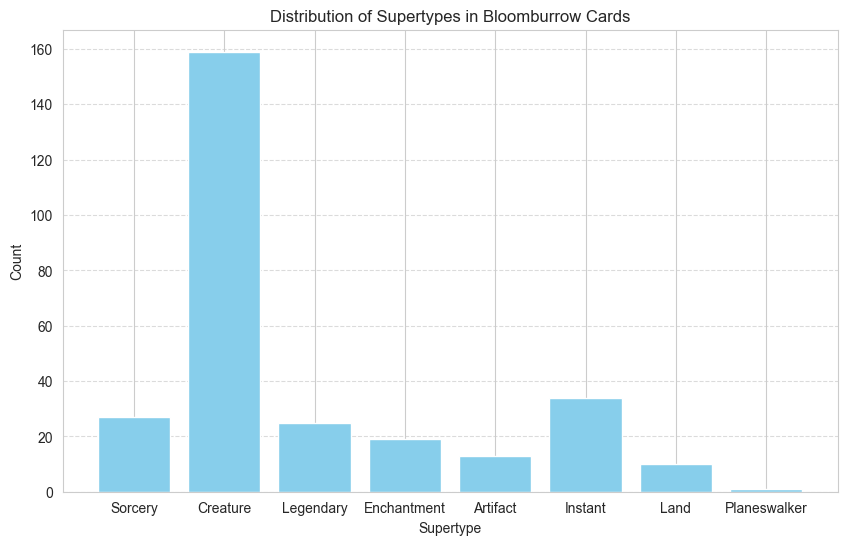

In [36]:
# Extract supertypes
supertype_counts = Counter()

for type_line in blb_df['type_line'].dropna():
    supertypes = type_line.split(" — ")[0].split()  # Get everything before the dash, split by spaces
    supertype_counts.update(supertypes)  # Count occurrences

# Convert counts to a dataframe for plotting
supertype_df = pd.DataFrame(supertype_counts.items(), columns=['Supertype', 'Count'])

# Plot the bar graph
plt.figure(figsize=(10, 6))
plt.bar(supertype_df['Supertype'], supertype_df['Count'], color="skyblue")
plt.xlabel("Supertype")
plt.ylabel("Count")
plt.title("Distribution of Supertypes in Bloomburrow Cards")
plt.xticks()
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

##### Type Distribution

Different sets will have different distributions, but creatures will always be most common. Bloomburrow is a particularly creature-focused set, with comparatively few enchantments and artifacts. Cards with multiple types are counted twice here (Legenday Creatures count for Legendary and Creature).

## Modeling

This notebook will show a simplified process flow that does NOT include Neural net, as the Tensorflow/Keras and XGBoost imports do not play nicely together. For the NN code, see the original blb_modeling.ipynb file. 	[modeling file](blb_modeling.ipynb)